### Training notebook (pre-trained EfficientNetB0 included)

**@detker, github.com/detker** 

In [22]:
#importing libs
import keras
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm

In [24]:
#creating labels for predictions
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [25]:
#loading, resizing image data
X_data = []
y_data = []

for x in labels:
    path = os.path.join('Training', x)
    
    for y in tqdm(os.listdir(path)):
        image = cv2.imread(os.path.join(path, y))
        image = cv2.resize(image, (150, 150))
        
        X_data.append(image)
        y_data.append(x)

for x in labels:
    path = os.path.join('Testing', x)
    
    for y in tqdm(os.listdir(path)):
        image = cv2.imread(os.path.join(path, y))
        image = cv2.resize(image, (150, 150))
        
        X_data.append(image)
        y_data.append(x)

X_data = np.array(X_data)
y_data = np.array(y_data)

100%|██████████| 300/300 [00:03<00:00, 88.68it/s]


In [27]:
X_data, y_data = shuffle(X_data, y_data, random_state=101)

(7023, 150, 150, 3)

In [28]:
#splitting data on training and validating parts
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.1, random_state=42)

In [29]:
#categorize 1 to n
y_train = [labels.index(x) for x in y_train]
y_valid = [labels.index(x) for x in y_valid]

y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)

In [30]:
eff_net = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

In [31]:
#model's architecture
eff_out = eff_net.output
pooling_layer = GlobalAveragePooling2D()(eff_out)
dropout = Dropout(0.5)(pooling_layer)
output_dense = Dense(4, activation='softmax')(dropout)

model = Model(eff_net.input, output_dense)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 150, 150, 3)  0           ['normalization[0][0]']      

                                                                                                  
 block2a_activation (Activation  (None, 38, 38, 96)  0           ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 96)          0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 96)     0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_se_reduce (Conv2D)     (None, 1, 1, 4)      388         ['block2a_se_reshape[0][0]']     
          

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [33]:
#useful callbacks
modelcheckpoint = ModelCheckpoint('model-output/v5/weights.h5', monitor='val_accuracy',
                                  save_best_only=True, mode='auto', verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience = 2, min_delta = 0.00,
                             mode='auto', verbose=1)

In [12]:
#clearing cache and training!
keras.backend.clear_session()
logs = model.fit(X_train, y_train, validation_split=0.1, epochs=12, verbose=1, batch_size=20,
                 callbacks=[modelcheckpoint, reducelr])

Epoch 1/12
285/285 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.8928
Epoch 1: val_accuracy improved from -inf to 0.87975, saving model to model-output/v5\weights.h5
285/285 [==============================] - 235s 750ms/step - loss: 0.2956 - accuracy: 0.8928 - val_loss: 0.3465 - val_accuracy: 0.8797 - lr: 0.0010
Epoch 2/12
285/285 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.9592
Epoch 2: val_accuracy improved from 0.87975 to 0.93038, saving model to model-output/v5\weights.h5
285/285 [==============================] - 201s 705ms/step - loss: 0.1206 - accuracy: 0.9592 - val_loss: 0.2000 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 3/12
285/285 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9675
Epoch 3: val_accuracy did not improve from 0.93038
285/285 [==============================] - 206s 723ms/step - loss: 0.0988 - accuracy: 0.9675 - val_loss: 0.3467 - val_accuracy: 0.9272 - lr: 0.0010
Epoch 4/12
285/285 [==

In [35]:
#predictions, evaluations, ...
predictions = model.predict(X_valid)
y_hat = np.argmax(predictions, axis=1)
y_real = np.argmax(y_valid, axis=1)

22/22 [==============================] - 8s 302ms/step


<Axes: >

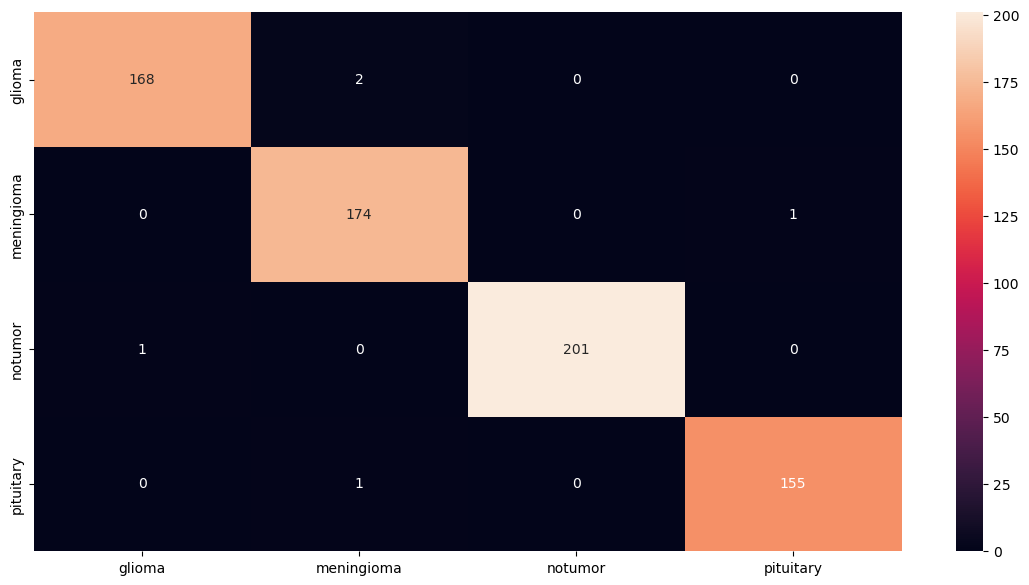

In [36]:
#plotting the confusion matrix
plt.figure(figsize=(14, 7))
sns.heatmap(confusion_matrix(y_real, y_hat), xticklabels=labels, yticklabels=labels, annot=True, fmt='d')

**It seems that model classification is without a doubt excellent. Accuracy is above 98%**

In [34]:
#loading weights from best epoch
model.load_weights('model-output/v5/weights.h5')

In [37]:
#saving the model
model.save('model-5.h5')